# LVL1 WX Code

In [1]:
#import external libraries
import pandas as pd
import os
pd.options.mode.chained_assignment = None  # default='warn'; chained index warning
import numpy as np
import imp
import datetime
import pytz

#plotting
import seaborn as sns; sns.set(style='whitegrid')
import matplotlib.pyplot as plt
%matplotlib notebook

#import self-written libraries
import CleanWxData as wx
import LVL1

In [2]:
imp.reload(LVL1)

<module 'LVL1' from 'C:\\Users\\ehbaker\\Documents\\Python\\Modules\\LVL1.py'>

** Define Location-Specific Baseline Settings **

In [3]:
#path to level 0 data
Glacier="Wolverine" #or "Gulkana"
Station="990" #or other elevations; this depends on the naming convention of input data
timezone='America/Anchorage' #choose from pytz.all_timezones
pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL0/" + Glacier.lower()+"_990_ALL_15minLVL0.csv"

#time format and column
UTC_time_column_name='UTC_time'
date_format='%Y/%m/%d %H:%M'

#directory to save output data
save_pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL1/emily/" + Glacier.lower()+"_990_ALL_15minLVL1.csv"

### Data import
- read in data 
- set timezone
- set time as index

In [4]:
#read in level0 CSV
dat=pd.read_csv(pth)

#TIME SHOULD BE DEALT WITH IN LEVEL0 PROCESSING (aka before this); LEVEL 0 will have time in UTC.
#I'm doing it here because it is currently NOT; shift this block to level 0 processing when possible.
dat['time']=pd.to_datetime(dat[UTC_time_column_name], format= date_format) #this is not actually UTC time; it's UTC-8
#dat=dat.set_index("time") #Set this time object as the index (for ease of indexing in Pandas dataframe)
dat['UTC']=dat.time + datetime.timedelta(hours=8) #This is now UTC time #THIS NAME MUST BE USED!

#Convert date to date-time object, and index of dataframe
dat['UTC']=pd.to_datetime(dat.UTC, format=date_format)
dat=dat.set_index("UTC") #Set this UTC time object as the index of the dataframe

#Timezone
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)
dat['local_time'] = dat.index.tz_localize('UTC').tz_convert(local_timezone)
dat=dat.set_index('local_time')

#Create QC-Flag identical dataframe - will store QC status of each value
dat_qc_info = pd.DataFrame().reindex_like(dat)

Station-specific Data Adjustments

In [5]:
# Wolverine990: Prior to 2014.04.20, asp. temperature only aspirated on the hour; other msmts set to NAN
if Glacier+Station=="Wolverine990":
    dat.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=np.nan
    dat_qc_info.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=1 #seet QC flag to 1, indicating removed values
    dat.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=np.nan
    dat_qc_info.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=1

** Remove malfunctioning sensors manually **
* done separately for each timestep entered on look-up table

In [6]:
#read in table listing sensors and timeperiods that need to be modified
pth_bad_sensor_dates=r"Q:\Project Data\GlacierData\Benchmark_Program\Metadata\weather"
bad_sensor_dates_dat=pd.read_csv(os.path.join(pth_bad_sensor_dates, Glacier+Station+"_SensorLog.csv"))

#Set bad data to NAN. Move sensor data to correct column, if neccessary.
dat=LVL1.remove_malfunctioning_sensor_data(dat, bad_sensor_dates_dat)

** Set hard-coded cutoff values** (station specific)

In [7]:
if Glacier+Station=="Wolverine990":
    low_temp_cutoff=-40.0 #deg. C
    high_temp_cutoff=30.0

    precip_high_cutoff=0.015 #meters
    precip_drain_cutoff=-0.015
    obvious_error_precip_cutoff=0.3 #if 30 cm in 15 minutes, obviously an error.
    
    Stage_dies='2015/09/01 06:30:00' #time at which instrument was installed
    TPG_born='2012/10/02 00:00:00'

** Clean Temperature Data**

In [8]:
#Temperature
temp_columns=['Tpassive1', 'Tpassive2', 'TAspirated1', 'TAspirated2']
for temp_col in temp_columns:
    temps=dat.loc[:,temp_col]
    dat.loc[:,temp_col]=LVL1.remove_error_temperature_values(temps, low_temp_cutoff, high_temp_cutoff)

** Plot original precipitation data**

<IPython.core.display.Javascript object>


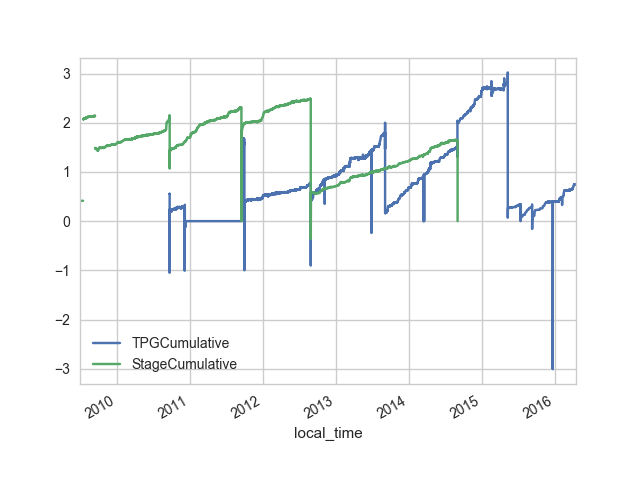

In [9]:
#Precip
precip_columns=['TPGCumulative', 'StageCumulative']
dat[precip_columns].plot()

** Clean Precipitation Data **

In [10]:
#Set gages to NAN, when not installed (single gage style does not cover period of record)
for precip_col in precip_columns:
    if 'TPG' in precip_col.upper():
        dat.loc[:TPG_born, precip_col]=np.nan
    if 'stage' in precip_col.lower():
        dat.loc[Stage_dies:, precip_col]=np.nan
        
#Remove obvious errors, with given hard-coded values set above
for precip_col in precip_columns:
    edited_values=LVL1.remove_error_precip_values(dat[precip_col], obvious_error_precip_cutoff, precip_high_cutoff, precip_drain_cutoff)
    dat[precip_col]=edited_values
    
data_before_smoothing=dat.copy() #save this data for later plotting    

<IPython.core.display.Javascript object>


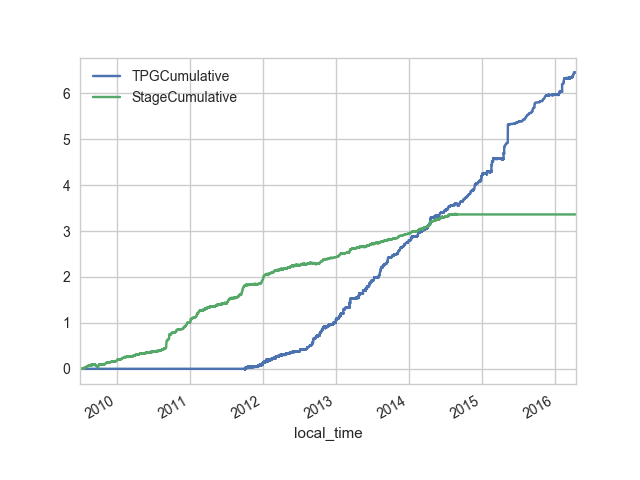

In [11]:
data_before_smoothing[precip_columns].plot()

** Initial outlier strip - hampel filter**
- remove drain and fill events

In [12]:
incremental_precip_columns=[] #initialize empty list that will hold column names of incremental precip; filled below
for precip_col in precip_columns:
    print("Starting " + precip_col)

    #strip outlier values using a 6-sample Hampel filter
    print("    Hampel Outlier Filter")
    dat[precip_col]=LVL1.hampel(dat[precip_col].values, k=3)

    #Create an incremental timeseries for precip
    dPrecip=precip_col.split("Cumulative")[0]+ "Incremental" #create name for new incremental column
    incremental_precip_columns.append(dPrecip)
    dat[dPrecip]=dat[precip_col] - dat[precip_col].shift(1)
    dat.loc[dat[dPrecip].isnull(), dPrecip]=0 #set increments that are NAN to 0 (error)

    #Precip drain and fill
    dat.loc[(dat[dPrecip]>precip_high_cutoff) & (dat.index.month>=8) & (dat.index.month<12), dPrecip]=0 #remove antifreeze fill
    dat.loc[(dat[dPrecip]<precip_drain_cutoff), dPrecip]=0 #remove negative values associated with drain events

    #Sensor malfunction, giving physically impossible high readings
    dat.loc[dat[dPrecip]>0.3, dPrecip]=0 #cutoff: 30cm in 15 min

data_after_first_smooth=dat.copy() #create copy of data at this step for later plotting comparrison

Starting TPGCumulative
    Hampel Outlier Filter
Starting StageCumulative
    Hampel Outlier Filter


**Plot cumulative timeseries: **

<IPython.core.display.Javascript object>


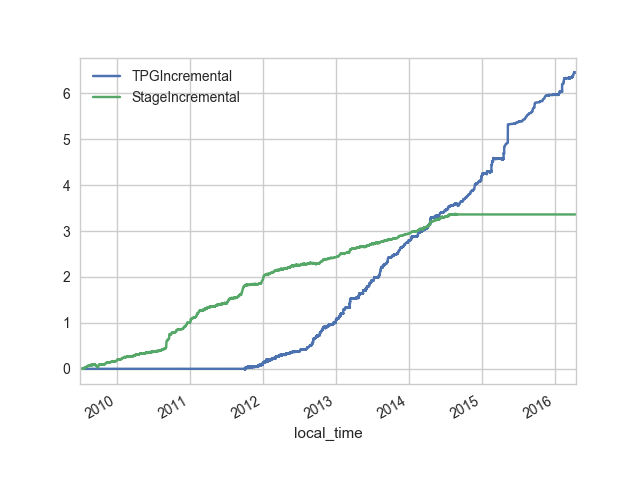

In [13]:
data_after_first_smooth[incremental_precip_columns].cumsum().plot()

In [14]:
for incr_precip_col in incremental_precip_columns:
    #Smooth this data with method from Nayak 2010
    print ("smoothing "+ incr_precip_col)
    dat=LVL1.smooth_precip_Nayak2010(dat, incr_precip_col)

data_after_second_smooth=dat.copy()

smoothing TPGIncremental
  smoothing data in forward direction; may take a minute
  done with forward smoothing
  smoothing data in reverse direction; may take a minute
  done with backwards
storing TPGIncremental_smooth
smoothing StageIncremental
  smoothing data in forward direction; may take a minute
  done with forward smoothing
  smoothing data in reverse direction; may take a minute
  done with backwards
storing StageIncremental_smooth


** Data After Second Smoothing **

<IPython.core.display.Javascript object>


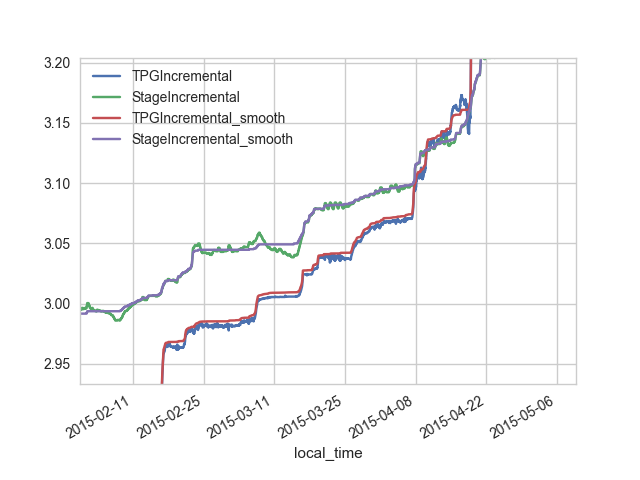

In [15]:
smoothed_columns=[s + "_smooth" for s in incremental_precip_columns] #names of columns post-smoothing
dat[incremental_precip_columns+smoothed_columns].cumsum().plot()

In [16]:
#Convert units from meters to mm
for col in smoothed_columns:
    dat.loc[:,col]=dat[col]*1000

In [19]:
#Set no-data values to NaN; not 0, as was neccessary for smoothin
for precip_col in smoothed_columns:
    if 'TPG' in precip_col.upper():
        dat.loc[:TPG_born, precip_col]=np.nan
    if 'stage' in precip_col.lower():
        dat.loc[Stage_dies:, precip_col]=np.nan

## Save Edited Data

In [20]:
#Time
dat['Local_time']=dat.index.tz_convert(local_timezone).strftime(date_format)#Create column for true local time (as string, not UTC - X hrs)
#Column Names
out_columns=['Local_time']+temp_columns+smoothed_columns+['RelHum', 'WindSpeed', 'WindGustSpeed', 'WindDir', 'LoggerTemp','LoggerBattery']
#Subset
save_dat=dat[out_columns] #removes unwanted columns
#Rename columns with "smooth" in them; match original naming
for col in smoothed_columns:
    newname=col.strip("_smooth")
    save_dat.rename(index=str, columns={col: newname}, inplace=True)

#Save
save_dat.to_csv(save_pth, index=False, float_format='%g')